-------- > epoch 1:  coût moyen entraînement = 0.394089013338089
-------- > epoch 1:  taux moyen entraînement = 0.890500545501709
-------- > epoch 1:  coût moyen test = 0.3721964359283447
-------- > epoch 1:  taux moyen test = 0.8982996344566345
-------- > epoch 2:  coût moyen entraînement = 0.3265261948108673
-------- > epoch 2:  taux moyen entraînement = 0.9077406525611877
-------- > epoch 2:  coût moyen test = 0.31025227904319763
-------- > epoch 2:  taux moyen test = 0.9126999378204346
-------- > epoch 3:  coût moyen entraînement = 0.29457923769950867
-------- > epoch 3:  taux moyen entraînement = 0.9168212413787842
-------- > epoch 3:  coût moyen test = 0.28541138768196106
-------- > epoch 3:  taux moyen test = 0.9200999736785889
-------- > epoch 4:  coût moyen entraînement = 0.27302080392837524
-------- > epoch 4:  taux moyen entraînement = 0.921440839767456
-------- > epoch 4:  coût moyen test = 0.2650912404060364
-------- > epoch 4:  taux moyen test = 0.9246000647544861
-------

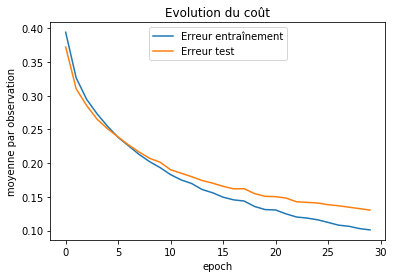

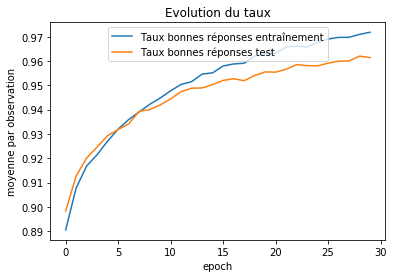

In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple simple de MNIST avec PyTorch
Production des métriques avec graphes
"""
import torch
torch.manual_seed(0) # Pour résultats reproductibles

# Fonction J d'entropie croisée
import torch.nn.functional as F
fonction_cout = F.cross_entropy

def taux_bonnes_predictions(lot_Y_predictions, lot_Y):
    predictions_categorie = torch.argmax(lot_Y_predictions, dim=1)
    return (predictions_categorie == lot_Y).float().mean()

from torch import nn
# Définition de l'architecture du RNA
class RNASimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.couche_lineaire1 = nn.Linear(784, 30)
        self.couche_lineaire2 = nn.Linear(30, 10)

    def forward(self, lot_X):
            lot_X = F.relu(self.couche_lineaire1(lot_X))
            return self.couche_lineaire2(lot_X)
modele = RNASimple()
    
from torch import optim
optimiseur = optim.SGD(modele.parameters(), lr=0.05)

# Chargement des données de MNIST
import pickle, gzip
fichier_donnees = gzip.open(r"mnist.pkl.gz", 'rb')
((donnees_ent_X, donnees_ent_Y),(donnees_valid_X, donnees_valid_Y),(donnees_test_X,donnees_test_Y)) = pickle.load(fichier_donnees, encoding="latin-1")
fichier_donnees.close()

# Conversion des données en type toch.Tensor
import torch
donnees_ent_X, donnees_ent_Y, donnees_test_X,donnees_test_Y = map(torch.tensor, (donnees_ent_X, donnees_ent_Y, donnees_test_X,donnees_test_Y))

# Création des objets DataLoader pour itérer par lot
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
ds_ent = TensorDataset(donnees_ent_X, donnees_ent_Y)
dl_ent = DataLoader(ds_ent, batch_size=100, shuffle=True)
ds_test = TensorDataset(donnees_test_X,donnees_test_Y)
dl_test = DataLoader(ds_test, batch_size=100)

graph_cout=True
if graph_cout :
    liste_cout_moyen_ent = []
    liste_taux_moyen_ent = []
    liste_cout_moyen_test = []
    liste_taux_moyen_test = []

nb_epochs = 30
# Boucle d'apprentissage
for epoch in range(nb_epochs):
#    cout_total_ent = 0
    modele.train() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
    
    # Boucle d'apprentissage par mini-lot pour une epoch
    for lot_X, lot_Y in dl_ent:
        optimiseur.zero_grad() # Remettre les dérivées à zéro
        lot_Y_predictions = modele(lot_X) # Appel de la méthode forward
        cout = fonction_cout(lot_Y_predictions, lot_Y)
#         cout_total_ent +=cout
        cout.backward() # Calcul des dérivées par rétropropagation
        optimiseur.step() # Mise à jour des paramètres
        
#     cout_moyen_ent = cout_total_ent/len(dl_ent)
#     print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
   
    modele.eval() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
    with torch.no_grad():
        cout_ent = sum(fonction_cout(modele(lot_ent_X), lot_ent_Y) for lot_ent_X, lot_ent_Y in dl_ent)
        taux_bons_ent = sum(taux_bonnes_predictions(modele(lot_ent_X), lot_ent_Y) for lot_ent_X, lot_ent_Y in dl_ent)        
        cout_test = sum(fonction_cout(modele(lot_test_X), lot_test_Y) for lot_test_X, lot_test_Y in dl_test)
        taux_bons_test = sum(taux_bonnes_predictions(modele(lot_test_X), lot_test_Y) for lot_test_X, lot_test_Y in dl_test)
    cout_moyen_ent = cout_ent / len(dl_ent)
    taux_moyen_ent = taux_bons_ent/len(dl_ent)
    cout_moyen_test = cout_test / len(dl_test)
    taux_moyen_test = taux_bons_test/len(dl_test)
    print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
    print(f'-------- > epoch {epoch+1}:  taux moyen entraînement = {taux_moyen_ent}')
    print(f'-------- > epoch {epoch+1}:  coût moyen test = {cout_moyen_test}')
    print(f'-------- > epoch {epoch+1}:  taux moyen test = {taux_moyen_test}')


    if graph_cout:
        liste_cout_moyen_ent.append(cout_moyen_ent)
        liste_taux_moyen_ent.append(taux_moyen_ent)
        liste_cout_moyen_test.append(cout_moyen_test)
        liste_taux_moyen_test.append(taux_moyen_test)

# Affichage du graphique d'évolution de l'erreur quadratique
import numpy as np
import matplotlib.pyplot as plt
if graph_cout:
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_test,label='Erreur test')
    plt.title("Evolution du coût")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
    
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_ent,label='Taux bonnes réponses entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_test,label='Taux bonnes réponses test')
    plt.title("Evolution du taux")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
